## Requirements

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Load and clean dataset

In [2]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape

(4765, 13)

In [47]:
clean_dataset.head()

,name,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
0,11 Comae Berenices b,304.0,4.72307,Gas Giant,2007,19.40000,Jupiter,1.08,Jupiter,1.290000,0.892539,0.23,Radial Velocity
1,11 Ursae Minoris b,409.0,5.01300,Gas Giant,2009,14.74000,Jupiter,1.09,Jupiter,1.530000,1.400000,0.08,Radial Velocity
2,14 Andromedae b,246.0,5.23133,Gas Giant,2008,4.80000,Jupiter,1.15,Jupiter,0.830000,0.508693,0.00,Radial Velocity
3,14 Herculis b,58.0,6.61935,Gas Giant,2002,8.13881,Jupiter,1.12,Jupiter,2.773069,4.800000,0.37,Radial Velocity
4,16 Cygni B b,69.0,6.21500,Gas Giant,1996,1.78000,Jupiter,1.20,Jupiter,1.660000,2.200000,0.68,Radial Velocity


In [46]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)
df.head()

,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
0,304.0,4.72307,Gas Giant,2007,19.40000,Jupiter,1.08,Jupiter,1.290000,0.892539,0.23,Radial Velocity
1,409.0,5.01300,Gas Giant,2009,14.74000,Jupiter,1.09,Jupiter,1.530000,1.400000,0.08,Radial Velocity
2,246.0,5.23133,Gas Giant,2008,4.80000,Jupiter,1.15,Jupiter,0.830000,0.508693,0.00,Radial Velocity
3,58.0,6.61935,Gas Giant,2002,8.13881,Jupiter,1.12,Jupiter,2.773069,4.800000,0.37,Radial Velocity
4,69.0,6.21500,Gas Giant,1996,1.78000,Jupiter,1.20,Jupiter,1.660000,2.200000,0.68,Radial Velocity


In [48]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
df.head()

,distance,stellar_magnitude,planet_type,discovery_year,orbital_radius,orbital_period,eccentricity,detection_method,mass,radius
0,304.0,4.72307,Gas Giant,2007,1.290000,0.892539,0.23,Radial Velocity,3.682120e+28,75503.88
1,409.0,5.01300,Gas Giant,2009,1.530000,1.400000,0.08,Radial Velocity,2.797652e+28,76202.99
2,246.0,5.23133,Gas Giant,2008,0.830000,0.508693,0.00,Radial Velocity,9.110400e+27,80397.65
3,58.0,6.61935,Gas Giant,2002,2.773069,4.800000,0.37,Radial Velocity,1.544746e+28,78300.32
4,69.0,6.21500,Gas Giant,1996,1.660000,2.200000,0.68,Radial Velocity,3.378440e+27,83893.20


In [7]:
transformed_df = df.copy()
columns_to_log = ["distance", "orbital_period", "orbital_radius", "radius", "mass"]
for column in columns_to_log:
    transformed_df[column] = np.log10(transformed_df[column])
print(transformed_df, transformed_df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0     2.482874            4.72307     Gas Giant            2007   
1     2.611723            5.01300     Gas Giant            2009   
2     2.390935            5.23133     Gas Giant            2008   
3     1.763428            6.61935     Gas Giant            2002   
4     1.838849            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260  3.894814           16.06200  Neptune-like            2016   
4261  3.504743           14.67200  Neptune-like            2016   
4262  3.468643           15.57600  Neptune-like            2016   
4263  3.556423           15.42400  Neptune-like            2016   
4264  3.488692           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           0.110590       -0.049373          0.23  Radial Velocity   
1           0.184691        0.146128          0.08  R

## Standardization

Note for us to the future: When we do training, make sure to first separate the training and test set, and do the standardization separately, so no info "leaks" from the test set into our training set.

In [24]:
raw_df_wothout_type = df.copy()
raw_df_wothout_type = raw_df_wothout_type.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)
encoded_df = transformed_df.copy()
#encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

df_std = (df_without_type - np.mean(df_without_type, axis=0)) / np.std(df_without_type, axis=0)
print(np.std(df_std, axis=0))

#we add back everything
df_std["planet_type"] = encoded_df["planet_type"]
df_std["detection_method"] = encoded_df["detection_method"]
df_std["discovery_year"] = encoded_df["discovery_year"]
df_std

distance             1.0
stellar_magnitude    1.0
orbital_radius       1.0
orbital_period       1.0
eccentricity         1.0
mass                 1.0
radius               1.0
dtype: float64


,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius,planet_type,detection_method,discovery_year
0,-0.810455,-2.507892,1.359820,1.150910,1.082079,2.492298,1.442841,0,5,11
1,-0.600238,-2.416469,1.470212,1.348906,0.068518,2.375634,1.453186,0,5,13
2,-0.960452,-2.347623,1.074520,0.903621,-0.472049,1.899163,1.513332,0,5,12
3,-1.984223,-1.909940,1.854963,1.890851,2.028070,2.123407,1.483662,0,5,6
4,-1.861175,-2.037443,1.522973,1.547707,4.122764,1.477877,1.561103,0,5,1
...,...,...,...,...,...,...,...,...,...,...
4260,1.493112,1.067600,-0.250884,-0.323994,-0.472049,-0.320206,-0.204089,1,6,20
4261,0.856714,0.629293,-0.286302,-0.323994,-0.472049,-0.336035,-0.226857,1,6,20
4262,0.797817,0.914350,-0.207619,-0.158707,-0.472049,-0.382575,-0.302985,1,6,20
4263,0.941030,0.866420,-0.142060,-0.183224,-0.472049,-0.336035,-0.226857,1,6,20


In [9]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


## Classification problem

In [10]:
X = df_std.drop(["planet_type", "mass"], axis=1)
y_classification = df_std["planet_type"]
y_regression = df_std["mass"]

# PCA

In [11]:
pca = PCA()

X_pca = X.drop(["detection_method", "discovery_year"], axis=1)

B = pca.fit_transform(X_pca)
V = pca.components_.T

rho = pca.explained_variance_ratio_

threshold = 0.90
sum(rho[:2])

np.float64(0.785922623492417)

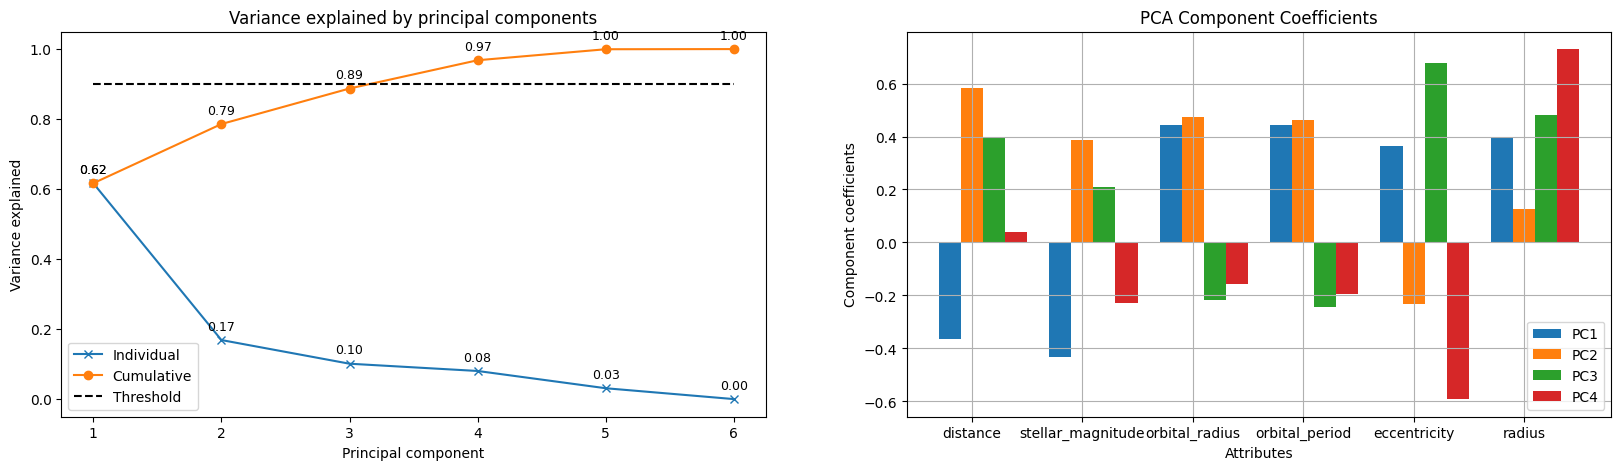

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(range(1, len(rho)+1), rho, "x-")
axs[0].plot(range(1, len(rho)+1), np.cumsum(rho), "o-")
axs[0].plot([1, len(rho)], [threshold, threshold], "k--")
axs[0].set_title("Variance explained by principal components")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Variance explained")
axs[0].legend(["Individual", "Cumulative", "Threshold"])
bw = 0.2

for i, val in enumerate(rho):
    axs[0].text(
        i + 1, 
        val + 0.02, 
        f'{val:.2f}', 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

r = np.arange(1, X_pca.shape[1] + 1)
axs[1].set_title("PCA Component Coefficients")
for i, pc in enumerate(V[:, :4].T):
    axs[1].bar(r + i * bw, pc, width=bw, label=f"PC{i+1}")
axs[1].set_xticks(r + bw, X_pca.columns)
axs[1].set_xlabel("Attributes")
axs[1].set_ylabel("Component coefficients")
axs[1].legend()
axs[1].grid()

for i, val in enumerate(np.cumsum(rho)):
    axs[0].text(
        i + 1, 
        val + 0.02, 
        f'{val:.2f}', 
        ha='center', 
        va='bottom', 
        fontsize=9
    )
plt.show()

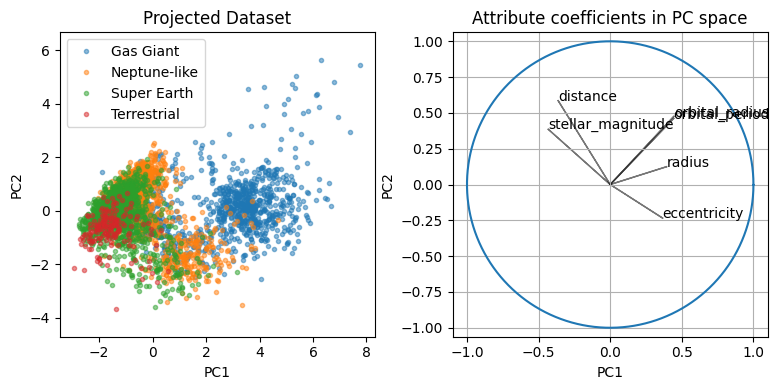

In [23]:
PC_idxs = [0, 1]
unique_types = np.unique(y_classification)

fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].set_title("Projected Dataset")
for type_index in unique_types:
    mask = (y_classification == type_index)
    axs[0].plot(B[mask, PC_idxs[0]], B[mask, PC_idxs[1]], ".", alpha=0.5, label=list(planet_cats.cat.categories)[type_index])

axs[0].set_xlabel(f"PC{PC_idxs[0] + 1}")
axs[0].set_ylabel(f"PC{PC_idxs[1] + 1}")
axs[0].axis("equal")
axs[0].legend()

axs[1].set_title("Attribute coefficients in PC space")
for attr_idx, attr_name in enumerate(X_pca.columns):
    axs[1].arrow(0, 0, V[attr_idx, PC_idxs[0]], V[attr_idx, PC_idxs[1]], color='black', alpha=0.5)
    axs[1].text(V[attr_idx, PC_idxs[0]], V[attr_idx, PC_idxs[1]], attr_name)
    
axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[1].set_xlabel(f"PC{PC_idxs[0] + 1}")
axs[1].set_ylabel(f"PC{PC_idxs[1] + 1}")
axs[1].grid()
axs[1].plot(np.cos(np.arange(0, 2 * np.pi, 0.01)), np.sin(np.arange(0, 2 * np.pi, 0.01)))
axs[1].axis("equal")
plt.tight_layout()
plt.show()

## Histogram

## Plotting attributes

Covariance Analysis

In [ ]:
df_raw = df.copy()
df_continous = df_std.drop(["planet_type", "detection_method", "discovery_year"], axis=1)
df_categorial = df_std[["planet_type", "detection_method", "discovery_year"]]

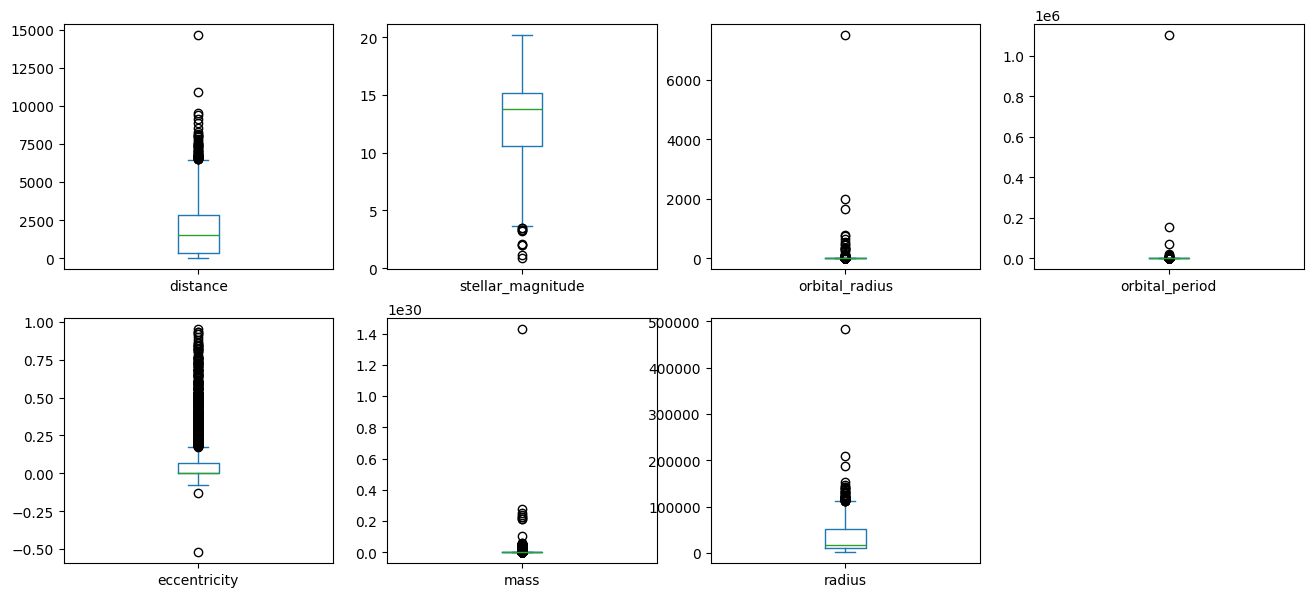

,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius
count,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000,4.000000e+03,4000.000000
mean,1824.755250,12.676328,5.065682,3.606425e+02,0.069860,2.770558e+27,31849.487875
std,1615.445559,3.171689,128.444015,1.762709e+04,0.148011,2.533279e+28,31635.322663
min,10.000000,0.872000,0.005800,5.475702e-04,-0.520000,1.642300e+23,1887.888000
25%,356.000000,10.540500,0.057095,1.451061e-02,0.000000,2.197696e+25,10778.820000
50%,1520.000000,13.779000,0.107000,3.723477e-02,0.000000,4.598440e+25,16219.352000
75%,2810.000000,15.130250,0.262700,1.405886e-01,0.070000,3.938445e+26,51069.985500
max,14624.000000,20.154400,7506.000000,1.101370e+06,0.950000,1.427296e+30,482385.900000


In [31]:
# Plot a boxplot of the attributes in X
raw_df_wothout_type.plot(kind='box', subplots=True, layout=(2, 4), figsize=(16,7), sharex=False, sharey=False)
plt.show()

# Compute summary statistics
raw_df_wothout_type.describe()

Based on the description we can observe that there are some outliers in our dataset, especially regarding the orbital radius, orbital period and mass.

In [35]:
#locate outliers
raw_df_wothout_type.iloc[np.where(raw_df_wothout_type["orbital_radius"] > 6000)]

,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius
84,36.0,11.298,7506.0,1101369.9,0.0,1.195740e+28,77601.21


Here the large orbital period matches the large orbital radius

In [37]:
full_df.iloc[np.where(raw_df_wothout_type["orbital_radius"] > 6000)]

,name,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
84,COCONUTS-2 b,36.0,11.298,Gas Giant,2021,6.3,Jupiter,1.11,Jupiter,7506.0,1101369.9,0.0,Direct Imaging


This is consistent with https://science.nasa.gov/exoplanet-catalog/coconuts-2-b/

In [44]:
#locate outliers
mass_outlier = raw_df_wothout_type.iloc[np.where(raw_df_wothout_type["mass"] > 1e+20)]

In [45]:
full_df.iloc[np.where(raw_df_wothout_type["mass"] > 10**30)]

,name,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
466,HD 100546 b,358.0,6.69,Gas Giant,2014,752.0,Jupiter,6.9,Jupiter,53.0,249.2,0.0,Direct Imaging


We can look it up: https://science.nasa.gov/exoplanet-catalog/hd-100546-b/
Here it says the mass is around 8.5 jupyters which is nothing close to 752 Jupyters, additionally the description mentions that the mass wasn't accurately measured so we can remove it.

In [25]:
outlier_pos = np.where(df_continous["mass"] > 50)
df_continous = df_continous.drop(outlier_pos[0], axis=0)
df_categorial = df_categorial.drop(outlier_pos[0], axis=0)
df_std = df_std.drop(outlier_pos[0], axis=0)

In [27]:
# get correlation from the unstandardized data. Correlation = covariance of the standardized data
cor_pairs = raw_df_wothout_type.corr()
cor_pairs

,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius
distance,1.000000,0.640362,-0.039125,-0.022176,-0.378312,-0.044693,-0.315808
stellar_magnitude,0.640362,1.000000,-0.029612,-0.008578,-0.529168,-0.115863,-0.582075
orbital_radius,-0.039125,-0.029612,1.000000,0.965116,-0.006273,0.031935,0.067090
orbital_period,-0.022176,-0.008578,0.965116,1.000000,-0.009268,0.010094,0.031680
eccentricity,-0.378312,-0.529168,-0.006273,-0.009268,1.000000,0.082765,0.479502
mass,-0.044693,-0.115863,0.031935,0.010094,0.082765,1.000000,0.353806
radius,-0.315808,-0.582075,0.067090,0.031680,0.479502,0.353806,1.000000


In [33]:
log_transformed_cor = df_without_type.corr()

<Axes: >

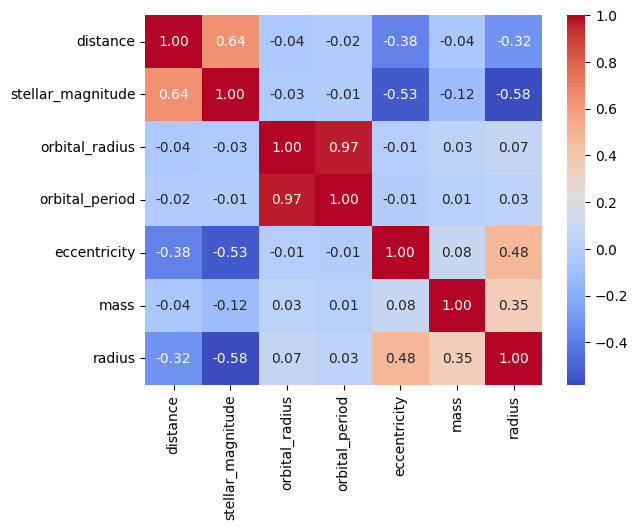

In [28]:
import seaborn as sns
sns.heatmap(cor_pairs, annot=True, fmt=".2f", cmap="coolwarm")

From the correlation matrix we can observe a few pairwise dependencies: What happens if a variable changes, how does the otehr variable follow. The closer to 1 means a positive correlation, the closer to -1 hints a negative correlation. The values around zero mean there is no significant correlation.
The orbital period is closely correlated with the orbital radiuis. This makes sense, as the bigger the readius, the longer the circumference which means a longer time to revolve around the star, thus a higher orbutal period.

Interestingly there seems to be a stronger negative correlation between stellar magnitude and radius. According to the dataset the brighter the planet is, the lower the stellar magnitude will be. Thus in this case the negative correlation means that the larger the radius is, the brighter the planet which aligns with our expectations.

Similarly the correlation between the stellar magnitude and distance describes the phenomena that the further a planet is from Earth the less bright it is.


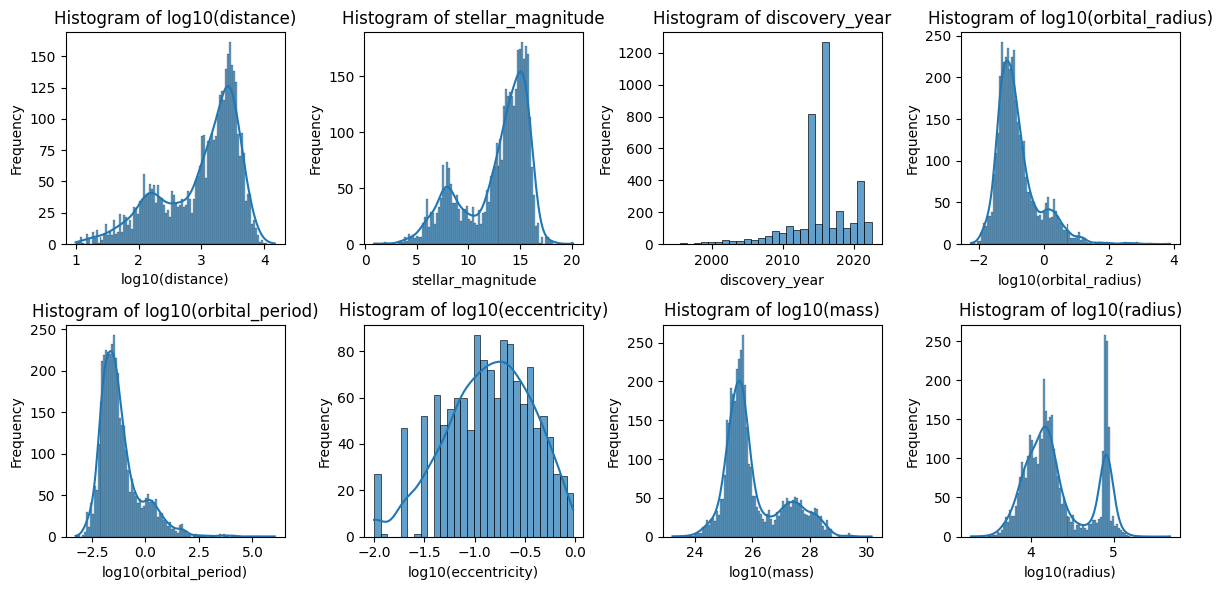

In [49]:
log10_cols = ["mass", "radius", "orbital_radius", "orbital_period", "distance", "eccentricity"]
# log10_cols = []

numeric_cols = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    data = df[col].dropna()
    if col in log10_cols:
        data = data[data > 0]
        data = np.log10(data)
        xlabel = f"log10({col})"
        title = f"Histogram of log10({col})"
    else:
        xlabel = col
        title = f"Histogram of {col}"
    if col == "discovery_year":
        sns.histplot(data, bins=np.arange(int(data.min()), int(data.max()) + 1) - 0.5, edgecolor='black', alpha=0.7, ax=ax)
    elif col == "eccentricity":
        sns.histplot(data, bins=30, kde=True, edgecolor='black', alpha=0.7, ax=ax)
    else:
        sns.histplot(data, bins=100, kde=True, edgecolor='black', alpha=0.7, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")
    ax.set_title(title)

plt.tight_layout()
plt.show()

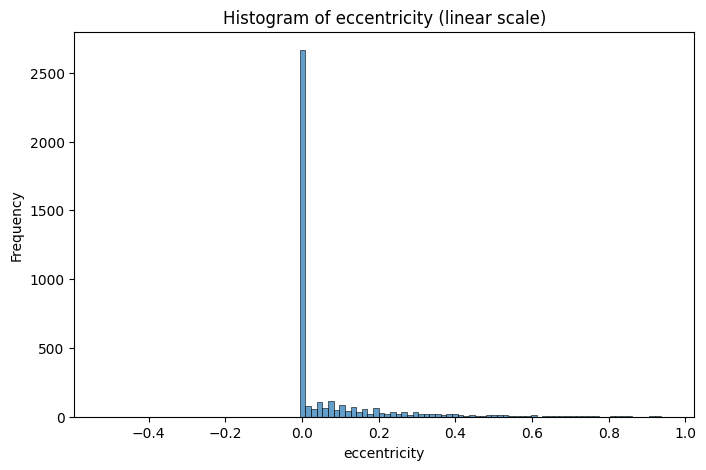

In [50]:
# Plot histogram of eccentricity (linear scale)
plt.figure(figsize=(8, 5))
sns.histplot(df["eccentricity"].dropna(), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel("eccentricity")
plt.ylabel("Frequency")
plt.title("Histogram of eccentricity (linear scale)")
plt.show()

In [51]:
numzero = np.count_nonzero(df["eccentricity"] == 0)
print(f"Number of zero eccentricity values: {numzero}")
print(f"Total number of values: {df['eccentricity'].shape[0]}")

Number of zero eccentricity values: 2665
Total number of values: 4000


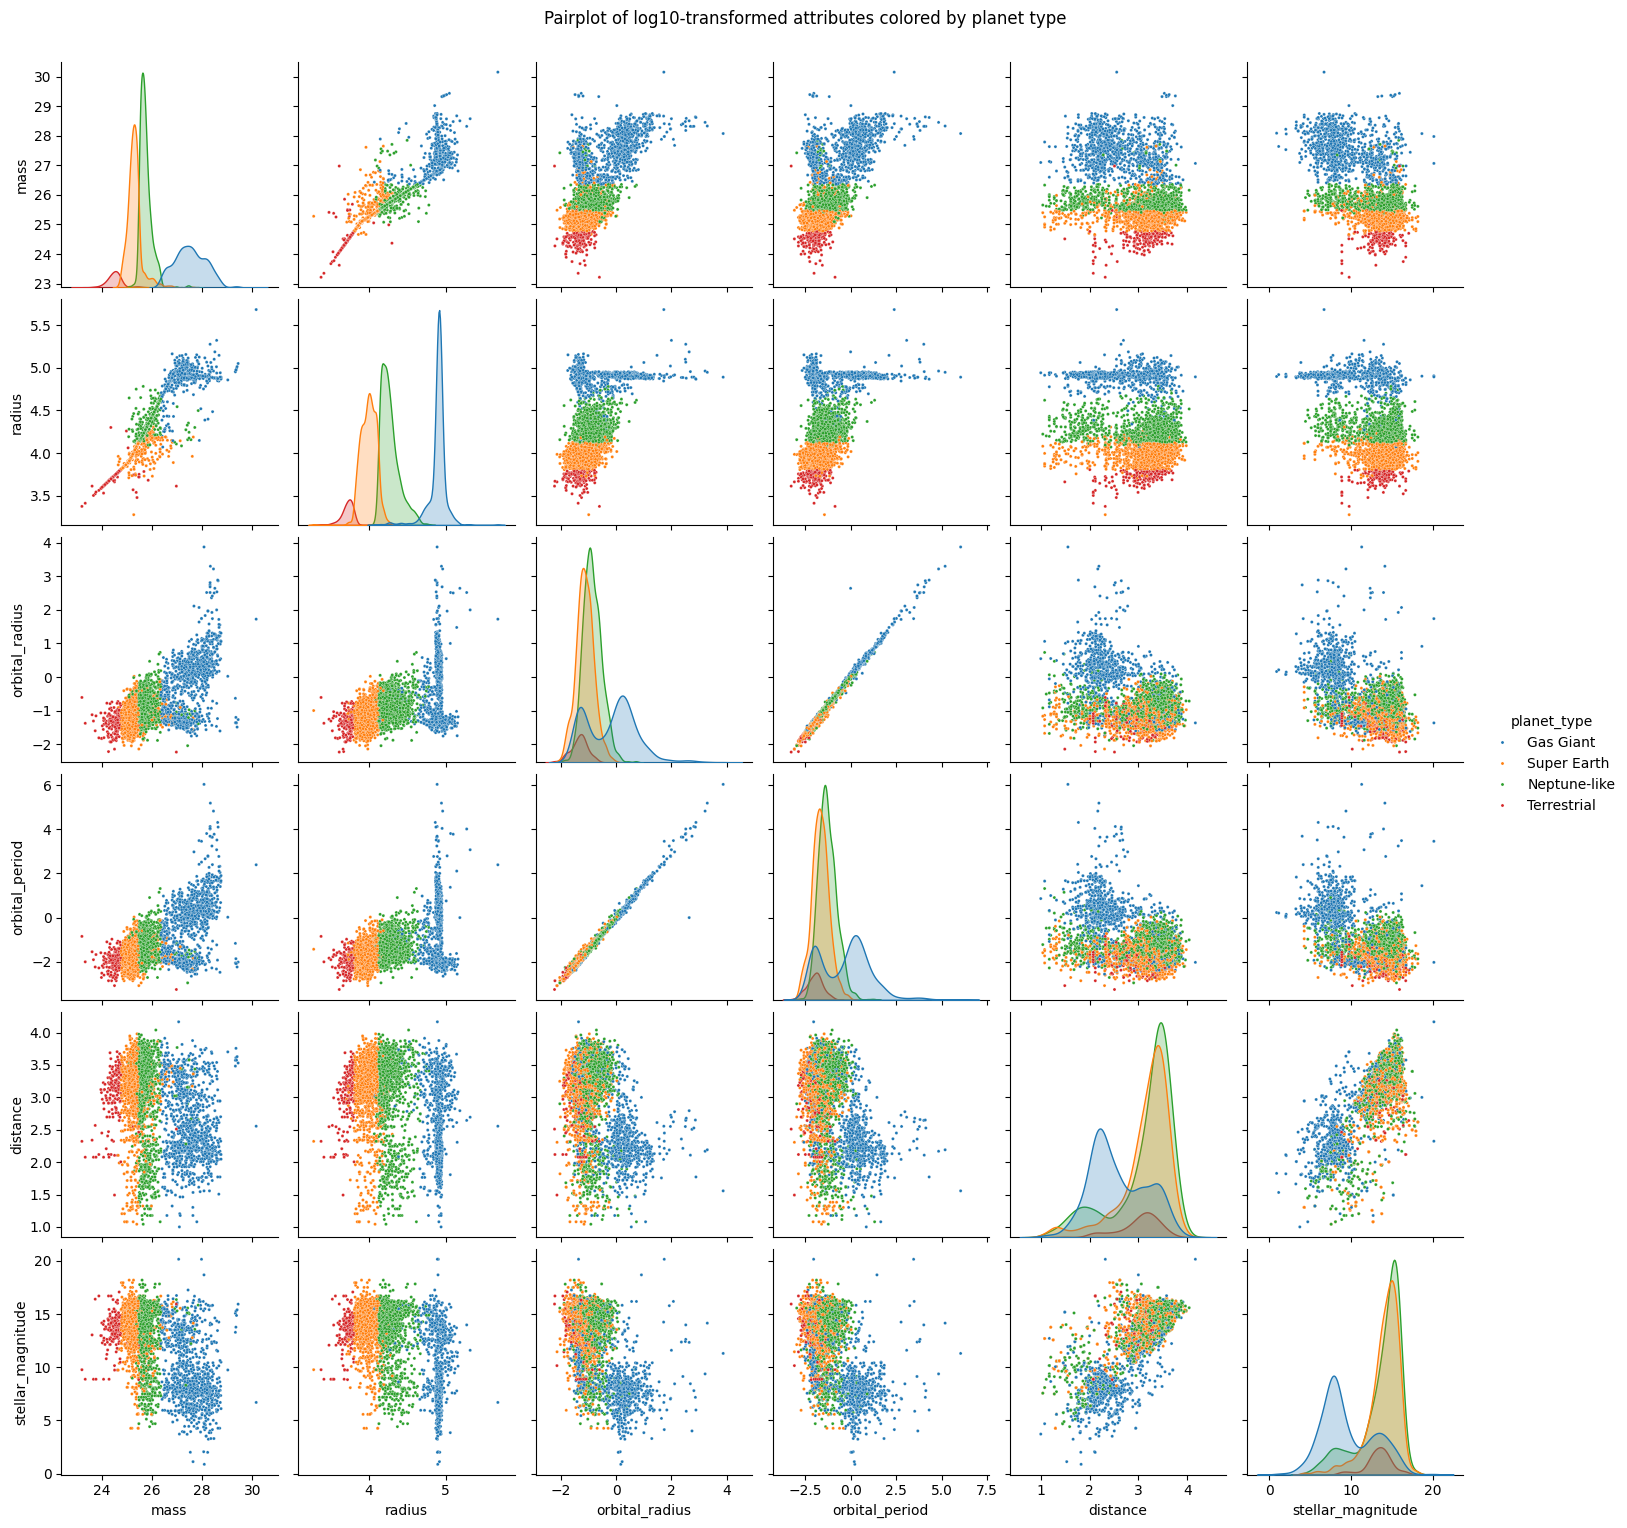

In [52]:
pairplot_df = df.copy()
log10_cols = ["mass", "radius", "orbital_radius", "orbital_period", "distance"]

# Apply log10 transformation to log-normal columns (avoid <=0 values)
for col in log10_cols:
    pairplot_df[col] = pairplot_df[col].apply(lambda x: np.log10(x) if x > 0 else np.nan)

cols_to_plot = log10_cols + ["planet_type", "stellar_magnitude"]

sns.pairplot(pairplot_df[cols_to_plot], hue="planet_type", diag_kind="kde", plot_kws={"s":5})
plt.suptitle("Pairplot of log10-transformed attributes colored by planet type", y=1.02)
plt.show()